In [18]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_hub as hub
import tensorflow_datasets as tfds

from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [21]:
import keras
from keras.applications.mobilenet import MobileNet
from sklearn.metrics import confusion_matrix
from keras.metrics import categorical_crossentropy
from keras.metrics import binary_crossentropy
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.mobilenet import preprocess_input
from tensorflow.keras.preprocessing import image_dataset_from_directory
import tensorflow as tf
from keras.preprocessing import image

In [22]:
train_datagen = image.ImageDataGenerator(
    rescale=1./255,
    shear_range = 0.3,
    zoom_range = 0.3,
    horizontal_flip = True,
)
validation_datagen = image.ImageDataGenerator(
    rescale = 1./255
)

In [23]:
train = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/Tomato data/Tomato Quality Grading Dataset/train',
    target_size = (224, 224),
    batch_size = 32,
    class_mode = 'categorical'
)

validation = validation_datagen.flow_from_directory(
    '/content/drive/MyDrive/Tomato data/Tomato Quality Grading Dataset/val',
    target_size = (224, 224),
    batch_size = 32,
    class_mode = 'categorical'
)

test = validation_datagen.flow_from_directory(
    '/content/drive/MyDrive/Tomato data/Tomato Quality Grading Dataset/test',
    target_size = (224, 224),
    batch_size = 32,
    shuffle = False,
    class_mode = 'categorical'
)

Found 5633 images belonging to 2 classes.
Found 799 images belonging to 2 classes.
Found 1597 images belonging to 2 classes.


In [24]:
VGG19 = tf.keras.applications.VGG19(
    include_top=False,
    weights = 'imagenet',
    input_shape=(224,224,3),
    )

In [25]:
VGG19.trainable = False

In [26]:
model = tf.keras.models.Sequential([
  VGG19,
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dropout(0.8),
  tf.keras.layers.Dense(units=1024, activation='relu'),
  tf.keras.layers.Dense(units=512, activation='relu'),
  tf.keras.layers.Dense(units=2, activation='sigmoid'),
])

In [27]:
model.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten_3 (Flatten)         (None, 25088)             0         
                                                                 
 dropout_3 (Dropout)         (None, 25088)             0         
                                                                 
 dense_9 (Dense)             (None, 1024)              25691136  
                                                                 
 dense_10 (Dense)            (None, 512)               524800    
                                                                 
 dense_11 (Dense)            (None, 2)                 1026      
                                                                 
Total params: 46241346 (176.40 MB)
Trainable params: 2

In [28]:
history = model.fit(
    x = train,
    validation_data = validation,
    epochs = 5
)

Epoch 1/5
177/177 [==============================] - 1575s 9s/step - loss: 0.7661 - accuracy: 0.7199 - val_loss: 0.6423 - val_accuracy: 0.6871
Epoch 2/5
177/177 [==============================] - 335s 2s/step - loss: 0.4147 - accuracy: 0.8182 - val_loss: 0.4453 - val_accuracy: 0.7935
Epoch 3/5
177/177 [==============================] - 356s 2s/step - loss: 0.3853 - accuracy: 0.8271 - val_loss: 0.5100 - val_accuracy: 0.7584
Epoch 4/5
177/177 [==============================] - 352s 2s/step - loss: 0.3713 - accuracy: 0.8372 - val_loss: 0.4367 - val_accuracy: 0.7922
Epoch 5/5
177/177 [==============================] - 339s 2s/step - loss: 0.3592 - accuracy: 0.8390 - val_loss: 0.4053 - val_accuracy: 0.8035


In [29]:
# Evaluate the loss and accuracy
loss, accuracy = model.evaluate(test)

# Print the accuracy
print("Accuracy: " + str(accuracy))
# Print the loss
print("Loss: " + str(loss))

50/50 [==============================] - 524s 11s/step - loss: 0.3335 - accuracy: 0.8610
Accuracy: 0.8609893321990967
Loss: 0.33345210552215576


In [30]:
test.class_indices

{'Fresh': 0, 'Rotten': 1}

In [31]:
import numpy as np
from sklearn import metrics

predictions = model.predict(test)
predicted_classes = np.argmax(predictions, axis = 1)
true_classes = test.classes
class_labels = ['Fresh', 'Rotten']
report = metrics.classification_report(true_classes, predicted_classes, target_names = class_labels)
print(report)

50/50 [==============================] - 13s 244ms/step
              precision    recall  f1-score   support

       Fresh       0.84      0.91      0.88       870
      Rotten       0.89      0.80      0.84       727

    accuracy                           0.86      1597
   macro avg       0.86      0.86      0.86      1597
weighted avg       0.86      0.86      0.86      1597



<Axes: >

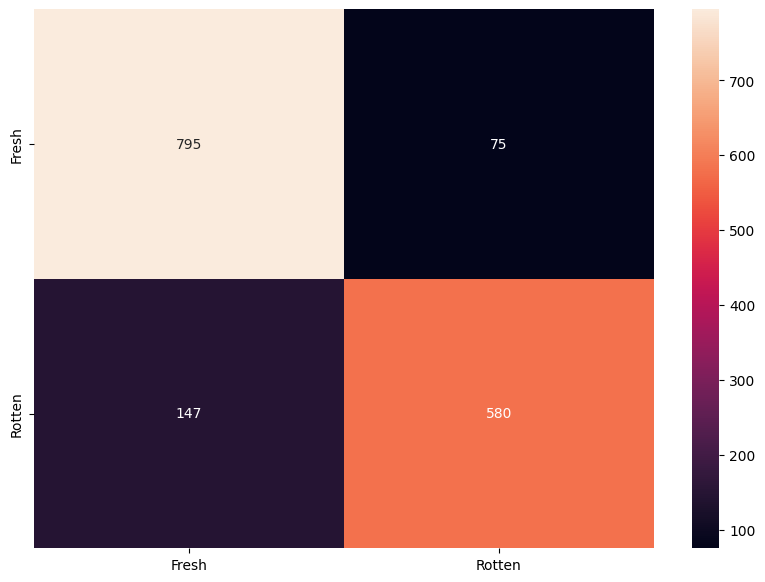

In [32]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

cm = metrics.confusion_matrix(true_classes, predicted_classes)
df_cm = pd.DataFrame(cm, index = [i for i in ['Fresh', 'Rotten']],
                  columns = [i for i in ['Fresh', 'Rotten']])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, fmt='d')

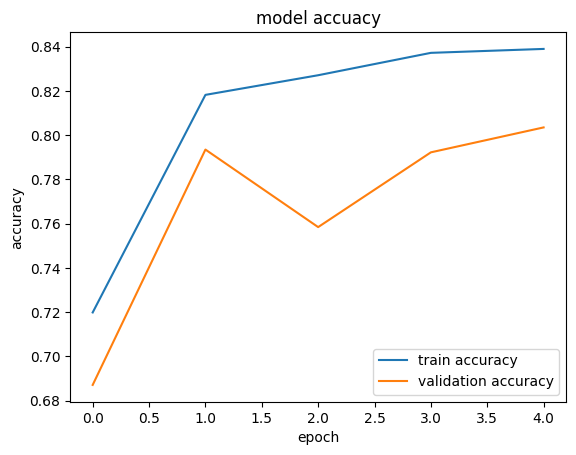

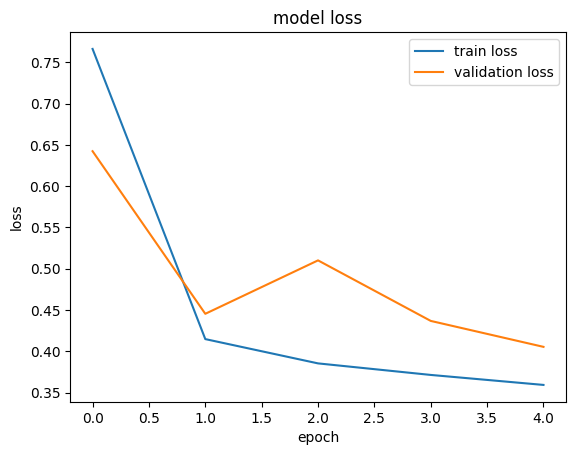

In [33]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("model accuacy")
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train accuracy', 'validation accuracy'], loc='lower right')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'], loc='upper right')
plt.show()